# Analysis of brainstorming transcript : convergent processes
The following is an ongoing analysis of transcripts from 18 teams; 9 of the teams performed what is called "free" brainstorming
The remaining 9 performed an alternating divergent-convergent process. The transcript for each team is split into its divergent and convergent components. 
This analysis concerns only the convergent components.

This version of the code attempts to NOT filter the code based on information content, bravely attempting to create interactive networks of the entire set of words. Here goes.

## Code credits
A lot of this code is inspired from, and in several cases reused directly from the code written by Moses Boudourides, Sergios Lenis & Pantelis Vikatos. Their version can be seen at:
http://mboudour.github.io/2016/03/22/Clinton-Sanders-Word-Nets.html

We change some aspects of the commonality functions and co-occurrence functions to suit our requirements, see code comments that accompany these functions below for details.

In [1]:
# Get all imports out of the way
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk.corpus import stopwords
from nltk.corpus.reader.wordnet import information_content
from nltk.tokenize import sent_tokenize
import itertools
import codecs
import re
import pprint as pp
import operator
from collections import OrderedDict
from collections import Counter
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## Step 1: Read Files
We first read the transcript text files. Each team's transcript is split into sections of
"divergent" processes (idea generation) and of "convergent" processes (idea evaluation/selection).
For this analysis, we will only look at the divergent processes. The goal is to understand what 
concepts are common between the two groups (Free and D-C), and what concepts are unique to each group.

In [2]:
# Locations of input files. These files have been anonymized, and the files themselves will not be available
# in this folder, to preserve the privacy of the teams.
textPathFree = "../../../private/brainstorming_viz_data/free_group/"
textPathDC = "../../../private/brainstorming_viz_data/d-c_group/"

# Teamwise transcript (of divergent processes) of the "Free Brainstorming" group
fileNamesFree = ['teamA_part2_convergent.txt',
                 'teamB_part2_convergent.txt',
                 'teamC_part2_convergent.txt',
                 'teamD_part2_convergent.txt',
                 'teamE_part2_convergent.txt',
                 'teamF_part2_convergent.txt',
                 'teamG_part2_convergent.txt',
                 'teamH_part2_convergent.txt',
                 'teamI_part2_convergent.txt']

# Teamwise transcript (of divergent processes) of the "Divergent-Convergent (D-C) Brainstorming" group
fileNamesDC = ['teamJ_part2_convergent.txt',
               'teamJ_part4_convergent.txt',
               'teamK_part2_convergent.txt',
               'teamK_part4_convergent.txt',
               'teamL_part2_convergent.txt',
               'teamL_part4_convergent.txt',
               'teamM_part2_3_convergent_divergent.txt',
               'teamM_part4_convergent.txt',
               'teamN_part2_convergent.txt',
               'teamN_part4_convergent.txt',
               'teamO_part2_3_conv_div.txt',
               'teamO_part4_convergent.txt',
               'teamP_part2_convergent.txt',
               'teamP_part4_convergent.txt',
               'teamQ_part2_convergent.txt',
               'teamQ_part3_4_div_conv.txt',
               'teamR_part2_convergent.txt',
               'teamR_part4_convergent.txt'] 

def openFiles(fileNamesList, filePath):
    # Given a list of file names and a path for the files, returns a
    # list of file objects
    fObjList = []
    for fileName in fileNamesList:
        fObj = open(filePath + fileName, 'r', encoding='utf8')
        fObjList.append(fObj)
    return fObjList

filesListFree = openFiles(fileNamesFree, textPathFree)
filesListDC = openFiles(fileNamesDC, textPathDC)

## Step 2: File processing
To avoid processing errors, we first remove all non-UTF characters in the text (such as distinct opening and closing quotes)
and replace them with corresponding UTF characters.
These transcripts also come with the transcriber's observations, such as [laughter], or [silent]. We remove all such observations so that we are only looking at team members' speech.

In [3]:
# Some of these files have non-UTF characters that may need to be removed.
def removeSpecials(filesList):
    # Remove some incompatible unicode characters such as distinct
    # opening and closing quotes, ellipsis etc.
    # Also finally converts all text to lowercase
    outString = ''
    for inFile in filesList:
        # print("reading file",inFile.name.split("/")[-1], "...", end="")
        temp = inFile.read()
        subsFileQuotes = re.sub(u"(\u2018|\u2019)", "'", temp)
        subsFileDQuotes = re.sub(u'(\u201c|\u201d)', '"', subsFileQuotes)
        subsFileEllipsis = re.sub(u"\u2026", "...", subsFileDQuotes)
        outString += subsFileEllipsis
        # print("done.")
    return outString.lower()

group1_convergent_raw = removeSpecials(filesListFree)
group2_convergent_raw = removeSpecials(filesListDC)

In [4]:
# These files have the transcriber's observations like [laughter], [silent], [cross-talk] etc.
# These may throw off the text analysis, so we remove them. These are typically within parantheses,
# so we can remove everything between these parantheses.

def removeObservations(test_str) :
    # removes all text within parantheses
    # these are usually observations by the transcriber
    # and thus should not be considered in content analysis
    # code from http://stackoverflow.com/questions/14596884/remove-text-between-and-in-python
    ret = ''
    skip1c = 0
    skip2c = 0
    squareparen = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
            squareparen += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
    print("Number of observations removed", str(squareparen))
    return ret

group1_convergent = removeObservations(group1_convergent_raw)
group2_convergent = removeObservations(group2_convergent_raw)

Number of observations removed 581
Number of observations removed 530


## Step 3: Tokenizing and stop word removal
We split the text from the transcripts into individual words. Of these, we remove "stop words" -- common words that add little meaning, such as articles, pronouns, prepositions etc. 
An added step would be to then "lemmatize" the resulting words so that words such as "short", "shorter", and "shortest" are treated the same (short), and words with different tenses, singular/plural forms etc. are also treated the same. However, we will do this at a later stage so that we can first identify all occurrences of the filtered words in the original text. To do this, we will need to implement whole-word matches, which will not be accurate if we were to lemmatize first.

In [5]:
# Split the file into words using a tokenizer
# Also name the variables a little more meaningfully
freeWords = nltk.word_tokenize(group1_convergent) 
DCWords = nltk.word_tokenize(group2_convergent)

# Remove stop words
freeWordsFiltered = [w for w in freeWords if not w in stopwords.words('english')]
DCWordsFiltered = [w for w in DCWords if not w in stopwords.words('english')]
freeDiff = len(freeWords) - len(freeWordsFiltered)
DCDiff = len(DCWords) - len(DCWordsFiltered)
print(freeDiff, "stop words removed from a total of", len(freeWords),"in the Free group")
print(DCDiff, "stop words removed from a total of", len(DCWords), "in the convergent-Convergent group")

12781 stop words removed from a total of 31090 in the Free group
18136 stop words removed from a total of 43106 in the convergent-Convergent group


In [6]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
wnL = WordNetLemmatizer()
ps = PorterStemmer()

# Lemmatize the tokenized words. This reduces singular, plural forms to the same form 
# to merge different forms of the same word together.
# to speed things up, remove non-unique words
# freeWordsUnique = list(set(freeWordsFiltered))
# print(len(freeWordsFiltered), "reduced to", len(freeWordsUnique), "unique words in free brainstorming transcript.")
# lemmatize the words
def genLemma(wordList):
    lemmaList = []
    for word in wordList:
        synsets = wn.synsets(word)
        if len(synsets) > 0 :
            synset = synsets[0] # assume most common use of the word
            sName = synset.name().split('.')[0]
            sPos = synset.pos()
            wordLemma = wnL.lemmatize(sName, pos=sPos)
            lemmaList.append(wordLemma)
    return lemmaList
        
            
# freeWordsLemmatized = [wnL.lemmatize(w) for w in freeWordsFiltered]
# freeWordsLemmatized = genLemma(freeWordsFiltered)
# NOTE: trying out a version without lemmatization to see the difference
freeWordsLemmU = list(set(freeWordsFiltered))
# freeWordsLemmU = list(set(freeWordsLemmatized))
print("Words in the Free Group reduced to", len(freeWordsLemmU), "unique occurrences.")

# NOTE: We choose to not do stemming as the stems cannot be processed by the WordNet library to find infocontent.

# Do the same for the D-C group
# NOTE: For the time being, we're doing away with lemmatization.
# DCWordsLemmatized = genLemma(DCWordsFiltered)
DCWordsLemmU = list(set(DCWordsFiltered))
print("Words in the D-C Group reduced to", len(DCWordsLemmU), "unique occurrences.")

Words in the Free Group reduced to 2142 unique occurrences.
Words in the D-C Group reduced to 2632 unique occurrences.


## ~~Step 4: Partition based on Information Content~~
~~As we can see, the resulting list of words is rather large and unmanageable. We "rank" these words based on information content.
Information content is a measure of how important a word is, and it depends on the likelihood of finding a word in a text corpus, i.e.~~

$$~~IC(w) = -log(P(w)) ~~$$

~~After iterating through all the text corpora available in WordNet, we settle on the British National Corpus as most suitable for our dataset, as it has the largest overlap with our dataset.~~

For this version, we do not attempt any of the above partitioning.

In [7]:
def getInfoContent(wordList, corpus):
    tokens = []
    icArray = []
    nonicArray = []
    for token in wordList:
        tempNum = 0
        synsets = wn.synsets(token)
        if len(synsets) > 0:
            for synset in synsets:
                if not set([synset.pos()]).intersection(set(['a','s','r'])) :
                    synsetItem = synset
                    tempNum = 1
                    break
            if tempNum == 1:
                infoContent = information_content(synsetItem, corpus)
                icArray.append((token, infoContent))
            else :
                nonicArray.append(token)
    icDict = dict(icArray)
    icTuple = sorted(icDict.items(), key=operator.itemgetter(1),
                     reverse=True)
    return [OrderedDict(icTuple), nonicArray]

corpusName = 'ic-bnc-add1'
ic_corpus = wordnet_ic.ic(corpusName + '.dat')
print("Computing infocontent with ",corpusName," corpus...", end="")
freeGroupProcessed = getInfoContent(freeWordsLemmU, ic_corpus)
DCGroupProcessed = getInfoContent(DCWordsLemmU, ic_corpus)
print("done.")

freeGrpInfoContents = freeGroupProcessed[0]
freeGrpNonInfoContents = freeGroupProcessed[1]
DCGrpInfoContents = DCGroupProcessed[0]
DCGrpNonInfoContents = DCGroupProcessed[1]
# freeGrpFrequencies = Counter(freeWordsLemmatized)
# DCGrpFrequencies = Counter(DCWordsLemmatized)
# NOTE: recall we're not using lemmatization anymore as we will look only for "exact matches" later on.
freeGrpFrequencies = Counter(freeWordsFiltered)
DCGrpFrequencies = Counter(DCWordsFiltered)
print("Number of words in the Free Group that could have infocontent computed:", len(freeGrpInfoContents))
print("Number of words in the D-C Group that could have infocontent computed:", len(DCGrpInfoContents))

# Find words for which infocontent could not be computed


Computing infocontent with  ic-bnc-add1  corpus...done.
Number of words in the Free Group that could have infocontent computed: 1674
Number of words in the D-C Group that could have infocontent computed: 2097


In [8]:
# # Partition each group's words into 3 based on infocontent scores
# print("Partitioning words based on infocontent values...\n")
# freeGroup_top3rd = {}
# freeGroup_mid3rd = {}
# freeGroup_bottom3rd = {}

# maxIC = max(freeGrpInfoContents[max(freeGrpInfoContents, key=freeGrpInfoContents.get)],
#             DCGrpInfoContents[max(DCGrpInfoContents, key=DCGrpInfoContents.get)])
# ic_top3rdLimit = 12
# ic_mid3rdLimit = 8
# for key, value in freeGrpInfoContents.items():
#     if value >= ic_top3rdLimit :
#         freeGroup_top3rd[key] = value
#     elif value >=ic_mid3rdLimit :
#         freeGroup_mid3rd[key] = value
#     else :
#         freeGroup_bottom3rd[key] = value
# print("Partitioning by infocontent in the Free Group:")
# print("Found a total of", len(freeGroup_top3rd), "words with infocontent between", ic_top3rdLimit ,"and", maxIC)
# print("Found a total of", len(freeGroup_mid3rd), "words with infocontent between", ic_mid3rdLimit, "and", ic_top3rdLimit)
# print("Found a total of", len(freeGroup_bottom3rd), "words with infocontent between 0 and", ic_mid3rdLimit, "\n") 

# DCGroup_top3rd = {}
# DCGroup_mid3rd = {}
# DCGroup_bottom3rd = {}
# DCGroup0_5 = {}
# for key, value in DCGrpInfoContents.items():
#     if value >= ic_top3rdLimit :
#         DCGroup_top3rd[key] = value
#     elif value >= ic_mid3rdLimit :
#         DCGroup_mid3rd[key] = value
#     else :
#         DCGroup_bottom3rd[key] = value
# print("Partitioning by infocontent in the D-C Group:")
# print("Found a total of", len(DCGroup_top3rd), "words with infocontent between", ic_top3rdLimit ,"and", maxIC)
# print("Found a total of", len(DCGroup_mid3rd), "words with infocontent between", ic_mid3rdLimit, "and", ic_top3rdLimit)
# print("Found a total of", len(DCGroup_bottom3rd), "words with infocontent between 0 and", ic_mid3rdLimit, "\n") 

## Step 5: Identifying common & unique words
Our overarching question is to identify behavior that is common to both groups (the free brainstorming group and the divergent-convergent brainstorming group), and behavior that is unique to each group. Identifying words common to both groups and words unique to each group is how we approach this transcript analysis.

In [30]:
def commUniq(group1Dict, group2Dict, group1Freq, group2Freq):
    common = {}
    # notCommon = {}
    group1Uncommon = {}
    group2Uncommon = {}
    u=1
    for i in group1Dict:
        if i in group2Dict:
            common[i] = min(group1Freq[i], group2Freq[i])
            # notCommon[i] = (group1Freq[i], group2Freq[i])
            u+=1
        else :
            group1Uncommon[i] = group1Freq[i]
    for i in group2Dict:
        if i not in group1Dict:
            group2Uncommon[i] = group2Freq[i]
    return (common, group1Uncommon, group2Uncommon)

print("Computing words common between the two groups...", end="")
common, freeGrp_uncommon, DCGrp_uncommon = commUniq(freeWordsLemmU, DCWordsLemmU, 
                                                               freeGrpFrequencies, DCGrpFrequencies)
print("Done.")
print("Number of common words found:", len(common))
print("Number of words that unique to the free group:", len(freeGrp_uncommon))
print("Number of words that unique to the D-C group:", len(DCGrp_uncommon))

Computing words common between the two groups...Done.
Number of common words found: 1135
Number of words that unique to the free group: 1007
Number of words that unique to the D-C group: 1497


## Step 5.1: Remove irrelevant words##
This step is to be performed only after generating a co-occurrence network first. Exploring the interactive network shown at Step 7 below allows us to identify words that add more noise than information to the graph. This is, of course, subjectively determined. These words are removed from consideration in the procedure below.

In [31]:
# Noun phrases that can be removed:
to_be_removed = ['yea', 'like', 'up', 'down', "!", "$", "'", "''", "'cause", 
                 "'d", "'em", "'ll", "'m", "'re", "'s", "'ve", ",", "yeah",
                 "-", ".", "1", "10", "12", "12.", "15", "20", "3-d", 
                 "30", "300", "352.", "36", "375", "3d", "452", "475", 
                 "475.", "90", ":", ";", "?", "``", "one", "would", "right",
                 "okay", 'could', 'know', 'make', 'something', 'yes', 'good',
                 "think", "oh", "maybe"]

keys_to_delete = []
for key in common.keys():
    if key in to_be_removed:
        keys_to_delete.append(key)
for key in keys_to_delete:
    del common[key] # could not have deleted item from iterable 
                    # from within the loop
commonFiltered=common.keys()
print("Number of common words in the top third after filtering:", len(commonFiltered))

Number of common words in the top third after filtering: 1084


## Step 6: Identify co-occurrences
We go over each sentence in the original dataset and look for word co-occurrences; pairs of words that occur in the same sentence. This helps us draw a concept map for each group's divergent brainstorming transcript data.

### NOTE
In this part of the analysis, we only look at words that are in the top stratum of information content (see results above).

In [11]:
# Function to count co-occurrences of common noun phrases in sentences
# NOTE: We're not using the function "occurrences" as found in the reference code anymore 
# for TWO main reasons:
# SPEED: For larger datasets, finding every possible co-occurrence in every sentence is very expensive;
# if 'word1' is not in 3000 of the 3100 sentences, looking for 'word1 and word2' and then 'word1 and word3'
# quickly becomes incredibly slow. The function below speeds things up a little.
# COMPLETE MATCH: The earlier code searched for noun phrases (could be more than one word). The search
# was designed to return partial matches, i.e. if it has to look for the word "rig" it returns sentences
# that have the word "right" but not "rig", creating a false count. This was less likely to be a problem
# when looking for noun phrases as there were lower chances of a 'false' partial match. In our case, 
# the risk is high. The original code also seems to consider the co-occurrences of word A and word B separately
# if A occurs before B from when B occurs before A. We rectify these issues below.

# That function will in turn call the below regexp to find whole words.
def findWholeWord(w):
    # regular expression to find whole words
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

def findOccurs(sentences, terms):
    # First find occurrences of every term in every sentence
    termOcc = []
    for ind, term in enumerate(terms):
        # search for term in all sentences.
        termData = [term, []]
        for sent in sentences:
            match = findWholeWord(term)(sent)
            if match :
                    termData[1].append(sent)
        if len(termData[1]) > 0:
            termOcc.append(termData)
    # Each entry in termOcc is now of the kind [term, [sent1, sent2,...]]
    # Now, to iterate through the termOcc list to find co-occurrences
    print("Term occurrences computed. Finding term co-occurrences...")
    occurdict = {}
    contextdict = {}
    for ind, termData in enumerate(termOcc):
        # search only through the REST of the list (to prevent repeat
        # counts)
        for cotermData in termOcc[ind+1:]:
            # NOTE : termData and coTermData are of type [term, [s1, s2,...]]
            for sent in termData[1]:
                match = findWholeWord(cotermData[0])(sent)
                if match :
                    wordkey = termData[0]+" - "+cotermData[0]
                    if wordkey in contextdict:
                        contextdict[wordkey] = contextdict[wordkey] + [sent]
                    else :
                        contextdict[wordkey] = [sent]
                    if wordkey in occurdict:
                        occurdict[wordkey] = occurdict[wordkey] + 1
                    else :
                        occurdict[wordkey] = 1
    return (occurdict, contextdict)
                
# pp.pprint(commonFiltered)
# Call function to find convergent and convergent terms
g1sentences = sent_tokenize(group1_convergent)
freeCooccur, freeContext= findOccurs(g1sentences, commonFiltered)
print("Number of unique co-occurrences found in the Free Group:", len(freeCooccur))

Term occurrences computed. Finding term co-occurrences...
Number of unique co-occurrences found in the Free Group: 8982


## Step 7: Plot word co-occurrence for the Free Brainstorming group
We use the data obtained in step 6 to plot a graph of co-occurrences in the "free brainstorming" group.
#### NOTE
We do not plot the graph as it takes up too much of the available resources, and is illegibly dense. We instead focus on obtaining the community partitions.

In [12]:
# Function to construct a graph of common noun phrases tied by 
# their co-occurrences in sentences of a transcript
def makegraph(occurrences):
    G = nx.Graph()
    weights = []
    for edgs,wt in occurrences.items():
        edg = edgs.split(' - ')
        G.add_edge(edg[0], edg[1], weight=wt)
        G.add_node(edg[0], label=edg[0])
        G.add_node(edg[1], label=edg[1])
        weights.append(wt)
    return [G, weights]

FreeGraphData = makegraph(freeCooccur)
GFree = FreeGraphData[0]
FreeEdges = FreeGraphData[1]

In [13]:
from networkx.drawing.nx_agraph import graphviz_layout
from bokeh import mpl
from bokeh.plotting import output_notebook, show, figure
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()

# First, create a graph layout
pos = nx.spring_layout(GFree, iterations=20)

def draw_interactive_network(graphObj, positions, wordFreq, wordCooccurs, wordContext, graphTitle):
    # Redrawing the graph from scratch so that the network may be interactive
    # NOTE: The current interactions are:
    # Hover on a node to show corresponding word's occurrences in the text
    # Hover on an edge center to show:
    #    * Number of co-occurrences that the edge indicates
    #    * The context, i.e., sentences in which the words co-occur.
    
    # Then obtain locations and metadata of the nodes from this layout
    xlocs = []
    ylocs = []
    nodeLabels = []
    nodeFreq = []
    nodeSizes = []
    for i in positions:
        nodeLabels.append(i)
        nodeFreq.append(str(wordFreq[i])+" occurrence(s)")
        nodeSizes.append(wordFreq[i]+10)
        xlocs.append(positions[i][0])
        ylocs.append(positions[i][1])

    # The eventual goal ofcontextHTML is to convert contextdict values 
    # from lists to html list items.
    # However, bokeh.js currently does not handle html tags *inside* variables.
    # Curently using the slightly ugly "||||" separator below
    contextHTML = {}
    for i in wordContext:
        conList = wordContext[i]
        conHTML = ""
        for item in conList:
            conHTML = conHTML + " " + item+" ||||"
        contextHTML[i] = conHTML.rstrip("|")

    # obtain locations and metadata of the edges from the layout
    edgeXpairs = []
    edgeYpairs = []
    edgeLabels = []
    edgeMidPtX = []
    edgeMidPtY = []
    edgeFreq = []
    edgeW = []
    edgeContext = []
    edgeListNames = wordCooccurs.keys()
    for i in graphObj.edges():
        w1 = i[0]
        w2 = i[1]
        w1x, w1y = positions[w1]
        w2x, w2y = positions[w2]
        edgeXpairs.append([w1x, w2x])
        edgeYpairs.append([w1y, w2y])
        edgeLabels.append(w1+" & "+w2)
        edgeMidPtX.append((w1x + w2x)/2)
        edgeMidPtY.append((w1y + w2y)/2)
        edgeString = w1 + ' - ' + w2
        edgeStringRev = w2 + ' - '+ w1
        if (edgeString in edgeListNames):
            edgeFreq.append(str(wordCooccurs[edgeString])+" co-occurrence(s)")
            edgeW.append(wordCooccurs[edgeString])
            edgeConString = contextHTML[edgeString]
            edgeContext.append(edgeConString)
        else :
            edgeFreq.append(str(wordCooccurs[edgeStringRev])+" co-occurrence(s)")
            edgeW.append(wordCooccurs[edgeStringRev])
            edgeConString = contextHTML[edgeStringRev]
            edgeContext.append(edgeConString)


    # Create a ColumnDataSource for the hover tool to reference
    dataPoints = dict(x = (xlocs + edgeMidPtX),
                      y = (ylocs + edgeMidPtY),
                      occ = (nodeFreq + edgeFreq),
                      desc = (nodeLabels + edgeLabels),
                      vis = ([1.0 for x in nodeLabels] + [0.0 for x in edgeLabels]),
                      size = (nodeSizes + [15 for x in edgeLabels]),
                      cxt = (["" for x in nodeLabels] + edgeContext))

    interact = ColumnDataSource(data = dataPoints)

    hover_data = HoverTool(tooltips ="""
                                   <text style="font-size: 17px; font-weight: bold;">@desc</text>
                                   <br>
                                   <text style="font-size: 15px">@occ</text>
                                   <div style="width:300px;font-size: 11px; font-face='Courier'">
                                       @cxt
                                   </div>
                                   """,
                                   point_policy='snap_to_data')

    p = figure(title = graphTitle, width=900, height=900)
    p.multi_line(edgeXpairs, edgeYpairs, color='gray', alpha=0.4, line_width=edgeW)
    p.circle('x', 'y', size='size', fill_color='#fed9a6', line_color=None, alpha='vis', source=interact)
    p.text(xlocs, ylocs, nodeLabels, text_font="Roboto", text_color='#333333', text_font_size='11pt', 
           text_align='center', text_baseline='middle' )

    p.add_tools(hover_data)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.visible = None
    show(p)

# draw_interactive_network(GFree, pos, freeGrpFrequencies, freeCooccur, freeContext, 
#                          "Co-occurrences in the Free Brainstorming Group")

Loading BokehJS ...

#### NOTE: ####
Move your mouse pointer over the **_nodes_** in the graph above to see the number of occurrences of the corresponding word in the transcript. You can also mouseover the **_mid-point of an edge_** to see both the number of co-occurrences of the two words it joins, and the context in which they co-occur.

## Step 8: Calculate centralities ##
The centralities of common words above can be calculated. Here, we look at the following centralities: NOTE: Most definitions here are from Wikipedia, but need to refine these to the definitions presented in corresponding papers.
### Betweenness Centrality ###
Defined for a node, this is equal to the number of shortest paths from all vertices to all others that pass through that node.
### Closeness Centrality ###
This is defined as the reciprocal of the sum of its distances from all other nodes.
### Degree Centality ###
This is defined as the number of links incident upon a node.
### Katz Centrality ###
Similar to Degree centrality, the Katz centrality measures the number of all nodes that can be connected through a path, while penalizing the contributions of distant nodes.
### Eigenvector Centrality ###
This is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes.
### PageRank ###
Similar to Katz centrality, the pagerank measure has an additional weighting measure that weights edges on their "influence" on the network (insert equation later).

In [14]:
%matplotlib inline
from tools import draw_centralities_subplots
# centrali=draw_centralities_subplots(GFree, pos, withLabels=True,labfs=5, figsi=(15, 15), ealpha=0.15, vals=True)

## Step 9: Identify Communities ##
Here communities are nothing but partitions that can be made to the network. The community identification is performed using the [Louvain method](http://arxiv.org/pdf/0803.0476.pdf). Python has an [implementation of the algorithm](http://perso.crans.org/aynaud/communities/) as part of the NetworkX library.

For details refer "tools.py" in the parent directory. Identifying these partitions can help us identify "themes" to each group's transcripts, helping us understand the group's behavior better.

Number of communities of  Co-occurrences in the Free Brainstorming Group  =  19
Community partition of  Co-occurrences in the Free Brainstorming Group :
[['boring',
  'doable',
  'children',
  'seen',
  'started',
  'complicated',
  'pro-e.',
  'watching',
  'star',
  'showed',
  'shit',
  'space',
  'call',
  'idea',
  'details',
  'fuck',
  'zombie',
  'modeling',
  'launched',
  'parallel',
  'everything',
  'shape',
  'goin',
  'stops',
  'going',
  'picking',
  'hair',
  'desk',
  'join',
  'exams',
  'range',
  'pretty',
  'damn',
  'since',
  'gas',
  'diverse',
  'mouth',
  'continue',
  'main',
  'million',
  'real',
  'outside',
  'match',
  'finished',
  'cry',
  'beginning',
  'worry',
  'bright',
  'looking',
  'army',
  'neat',
  'solar',
  'driver',
  'bad',
  'sick',
  'marketing',
  'men',
  'much',
  'terms',
  'bath',
  'lego',
  'stop',
  'commercial',
  'pro',
  'develop',
  'must',
  'matter',
  'office',
  'seems',
  'worse',
  'toys',
  'complex',
  'powered',
 

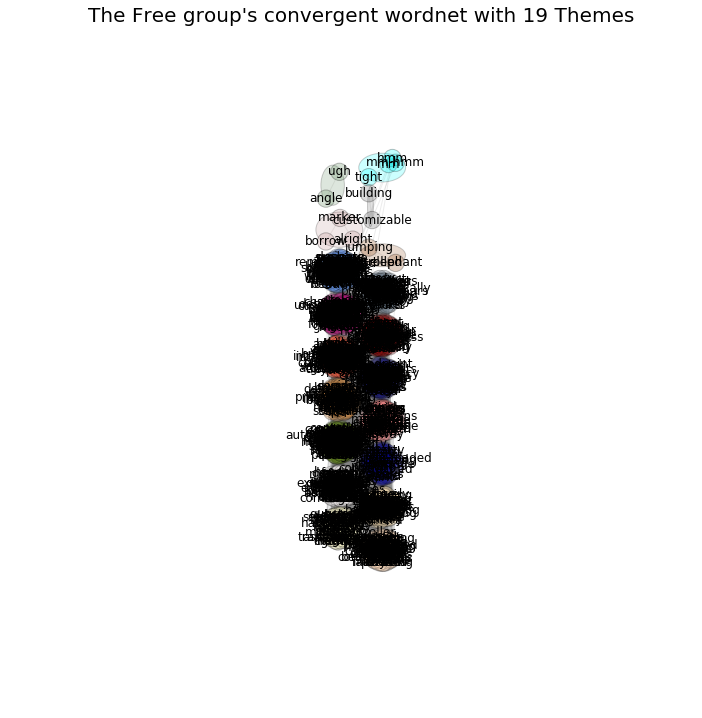

In [15]:
# detecting communities of common phrases
%reload_ext autoreload
%autoreload 2
from tools import draw_comms, modul_arity, print_communities
sstt = "Co-occurrences in the Free Brainstorming Group"
part, nodper = print_communities(GFree, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=0.15
vcc={}

sstta="The Free group's convergent wordnet with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GFree,GFree.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=12,valpha=0.25)

### Interpretation ###
An initial observation based on the communities detected and an observation of the raw data is that the communities show sets of related ideas. Based on this, we may have two possibilities:
1. **More communities with fewer words/community:** These could denote a greater "breadth" of idea evaluation (if the ideas are less related to each other). This should be the case for the Free brainstorming group.
2. **Fewer communities with more words/community:** These could denote a greater "depth" of idea evaluation (if the ideas have been explored to a greater depth during the divergent phase). This should be the case for the D-C brainstorming group.

## Step 10: Perform steps 7-9 for the Divergent-Convergent Group ##

In [16]:
# Identify co-occurrences of the common words in the D-C transcript dataset
g2sentences = sent_tokenize(group2_convergent)
DCCooccur, DCContext= findOccurs(g2sentences, common)
print("Number of unique co-occurrences found in the DC Group:", len(DCCooccur))

Term occurrences computed. Finding term co-occurrences...
Number of unique co-occurrences found in the DC Group: 9399


In [17]:
DCGraphData = makegraph(DCCooccur)
GDC = DCGraphData[0]
DCEdges = DCGraphData[1]
# pos1 = nx.spring_layout(GDC, iterations=20)

In [18]:
# draw_interactive_network(GDC, pos1, DCGrpFrequencies, DCCooccur, DCContext, 
#                         "Co-occurrences in the D-C Brainstorming Group")

In [19]:
from tools import draw_comms, modul_arity, print_communities
sstt = "Co-occurrences in the D-C Brainstorming Group"
part, nodper = print_communities(GDC, sstt)

# d=0.8 
# dd=0.8
# c=1.2
# cc=1.4
# alpha=0.2
# ealpha=0.15
# vcc={}

# sstta="The DC group's convergent wordnet with "+ str(max(part.values())+1) + " Themes" 
# draw_comms(GDC,GDC.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=12,valpha=0.25)

Number of communities of  Co-occurrences in the D-C Brainstorming Group  =  19
Community partition of  Co-occurrences in the D-C Brainstorming Group :
[['boring',
  'doable',
  'find',
  'many',
  'bounces',
  'square',
  'list',
  'nothing',
  'whenever',
  'train',
  'buoyancy',
  'super',
  'happy',
  'shooter',
  'shaped',
  'idea',
  'doll',
  'details',
  'table',
  'far',
  'figure',
  'pop',
  'crazy',
  'zombie',
  'parallel',
  'toy',
  'frisbee',
  'annoying',
  'thought',
  'stupid',
  'mean',
  'easier',
  'ding',
  'mass',
  'material',
  'dude',
  'ways',
  'customizable',
  'play',
  'crappy',
  'tough',
  'barbie',
  'say',
  'third',
  'expand',
  'meant',
  'range',
  'plenty',
  'score',
  'someone',
  'surprised',
  'live',
  'lot',
  'marker',
  'parts',
  'customize',
  'pitch',
  'monkey',
  'football',
  'motions',
  'fun',
  'terrible',
  'working',
  'game',
  'song',
  'stay',
  'high',
  'stack',
  'possible',
  'sell',
  'main',
  'level',
  'regular',
  '

## Step 11: Perform steps 7-9 for the words unique to each group ##
Our goal is also to see what words are unique to each group, and what information they may reveal about the teams in each group. We thus perform the co-occurrence analysis and generate networks for these sets of words, too.

In [20]:
keys_to_delete = []
for key in freeGrp_uncommon.keys():
    if key in to_be_removed:
        keys_to_delete.append(key)
for key in keys_to_delete:
    del freeGrp_uncommon[key] # could not have deleted item from iterable 
                    # from within the loop
freeGrp_uncommonFiltered=freeGrp_uncommon.keys()
print("Number of common words in the top third after filtering:", len(freeGrp_uncommonFiltered))

freeCooccur_unique, freeContext_unique = findOccurs(g1sentences, freeGrp_uncommonFiltered)
print("Number of unique co-occurrences found in the free Group:", len(freeCooccur_unique))

Number of common words in the top third after filtering: 1007
Term occurrences computed. Finding term co-occurrences...
Number of unique co-occurrences found in the free Group: 816


In [21]:
freeGraphDataU = makegraph(freeCooccur_unique)
GFreeU = freeGraphDataU[0]
freeEdgesU = freeGraphDataU[1]
# pos2 = nx.spring_layout(GFreeU, iterations=20)
# draw_interactive_network(GFreeU, pos2, freeGrpFrequencies, freeCooccur_unique, freeContext_unique, 
#                          "Co-occurrences of words unique to the Free Brainstorming Group")

In [22]:
# from tools import draw_centralities_subplots
# centrali=draw_centralities_subplots(GFreeU, pos2, withLabels=True,labfs=5, figsi=(15, 15), ealpha=0.15, vals=True)

In [23]:
sstt = "Co-occurrences in the Free Brainstorming Group"
part, nodper = print_communities(GFreeU, sstt)

# d=0.8 
# dd=0.8
# c=1.2
# cc=1.4
# alpha=0.2
# ealpha=0.15
# vcc={}

# sstta="The Free group's convergent wordnet with "+ str(max(part.values())+1) + " Themes" 
# draw_comms(GFree,GFree.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=12,valpha=0.25)

Number of communities of  Co-occurrences in the Free Brainstorming Group  =  147
Community partition of  Co-occurrences in the Free Brainstorming Group :
[['compartment', 'swimming'],
 ['talked',
  'lawsuit',
  'native',
  'c',
  'sensitive',
  'exam',
  'classes',
  'foot-long',
  'patent',
  'modular',
  'patented',
  'bitch',
  'pushbuttons',
  'pain',
  'that..',
  'hopeless',
  'integrate',
  'moms',
  'phase',
  'android',
  'delicate',
  'mini-ipad',
  'weather',
  'fsssssssssss',
  'volkswagen',
  'laid',
  'retarded',
  'detail',
  'wake',
  'burgers',
  'sparks',
  'trucks',
  'beyond',
  'due',
  'knowledge',
  'obvious',
  'sticking',
  'bent',
  'america',
  'shortcuts',
  'limiting',
  'exciting',
  'sophomore',
  'preliminary',
  'unusual',
  'window',
  'layout',
  'arrived',
  'gears',
  'runs',
  'define',
  'vehicles',
  'spell',
  'rabbit',
  'diesel',
  'bogan',
  'carrying',
  'fours',
  'apps',
  'ios',
  'elbow',
  'samsung',
  'counted',
  'otherwise',
  'spark

In [24]:
keys_to_delete = []
for key in DCGrp_uncommon.keys():
    if key in to_be_removed:
        keys_to_delete.append(key)
for key in keys_to_delete:
    del DCGrp_uncommon[key] # could not have deleted item from iterable 
                    # from within the loop
DCGrp_uncommonFiltered=DCGrp_uncommon.keys()
DCCooccur_unique, DCContext_unique = findOccurs(g2sentences, DCGrp_uncommonFiltered)
print("Number of unique co-occurrences found in the DC Group:", len(DCCooccur_unique))

Term occurrences computed. Finding term co-occurrences...
Number of unique co-occurrences found in the DC Group: 3613


In [25]:
DCGraphDataU = makegraph(DCCooccur_unique)
GDCU = DCGraphDataU[0]
DCEdgesU = DCGraphDataU[1]
# pos3 = nx.spring_layout(GDCU, iterations=20)
# draw_interactive_network(GDCU, pos3, DCGrpFrequencies, DCCooccur_unique, DCContext_unique, 
#                          "Co-occurrences of words unique to the DC Brainstorming Group")

In [26]:
from tools import draw_centralities_subplots
# centrali=draw_centralities_subplots(GFreeU, pos2, withLabels=True,labfs=5, figsi=(15, 15), ealpha=0.15, vals=True)

In [27]:
sstt = "Co-occurrences in the D-C Brainstorming Group"
part, nodper = print_communities(GDCU, sstt)

Number of communities of  Co-occurrences in the D-C Brainstorming Group  =  113
Community partition of  Co-occurrences in the D-C Brainstorming Group :
[['hovercraft',
  'blowing',
  'wearing',
  'insane',
  'stabilizing',
  'turbine',
  'floats',
  'film',
  'facial',
  'erecting',
  'compressor',
  'self-stabilizing',
  'line-following',
  'turbine-powered',
  'reducing',
  'legos',
  'elaborate',
  'titanic',
  'self-rights',
  'fork',
  'smiles',
  'discussing',
  'crane',
  'ends',
  'opening',
  'stretches',
  'personal',
  'self',
  'shade',
  'sunglasses',
  'explanatory',
  'opposed',
  'modify',
  'apart',
  'pocket',
  'upon',
  'puzzle',
  'stretch',
  'demand'],
 ['steppers',
  'darker',
  'finance',
  'axe',
  '12:30',
  'multi-point',
  'rectangle',
  'suit',
  'sufficient',
  'classic',
  'inward',
  'hubless',
  'curious',
  'scratch',
  'lifetime',
  'shoe',
  'helpful',
  'soaker',
  'life-sized',
  'painted',
  'plain',
  'physics',
  'calculations',
  'graduating',

## Observations ##
When compared to the earlier analysis of the [divergent processes](https://nbviewer.jupyter.org/github/senthilchandrasegaran/jupyter-notebooks/blob/master/brainstorming-viz/divergence_infocontent_interactive.ipynb), our  observations, tabulated below, are:

### Divergent Process ###
| Group              | Common Words   | Co-occurrences | Communities | Unique Words | Co-occurrences | Communities |
| ------------------ |----------------| ---------------|-------------|--------------| ---------------|-------------|
| Free Brainstorming | ---            | --             | --          | ---          | --             | --          |
| D-C Brainstorming  | ---            | --             | --          | ---          | --             | --          |

### Convergent Process ###
| Group              | Common Words   | Co-occurrences | Communities | Unique Words | Co-occurrences | Communities |
| ------------------ |----------------| ---------------|-------------|--------------| ---------------|-------------|
| Free Brainstorming | 1084           | 8982           | 16          | 1007         | 816            | 146         |
| D-C Brainstorming  | 1084           | 9399           | 21          | 1497         | 3613           | 108         |


## Inferences ##
There are overall more words spoken during the divergent process (average per team of 7245 for the Free Group) than during the convergent process (average: 3272 for the Free Group). It is thus not surprising to see a difference in the number of words with information content > 12. Note that this value of "12" is just an attempt to split the word list into three sections based on a visual inspection of words ordered by information content. 

This difference, however, does not exist for the D-C group (average per team of 5243 words for both divergent processes combined, and average of 5321 for both convergent processes combined). 

### Divergent Process ###
We looked at the words **_common_** to both groups to see the similarities between the groups. While a closer examination of the common words and where they occur in the text is needed, currently we can see that the number of these common words, and the number of co-occurrences of pairs of these words is similar across the two groups (columns 2 and 3 in the "Divergent Process" table. A similar result can be seen in the communities as well. Looking at the words **_unique_** to these communities also reveals a more  or less similar result; there is not much of a difference, at first glance, between the two groups when analyzing their divergent processes. An early interpretation of the results anticipated two possibilities:

1. **More communities with fewer words/community:** These could denote a greater "breadth" of idea genration (generating more ideas that are unrelated to each other). This should be the case for the Free brainstorming group.
2. **Fewer communities with more words/community:** These could denote a greater "depth" of ideas, i.e. a greater exploration of each idea. This should be the case for the D-C brainstorming group.

We can see that neither of this is apparent. Perhaps we may see a greater separation if we were to not exclude words with information content < 12? This may be worth running an overnight analysis.

### Convergent Process ###
Again, there is not much of a difference in the co-occurrences of words common in both groups (aided by the fact that _very few_ of the words are common). we can see that the number of words unique to the convergent process is higher for the D-C group, since the teams spent more time evaluating and refining ideas in the D-C group. The number of communities in the D-C brainstorming group is also higher. Though it appears to be the opposite of our expectations (that the D-C group will have fewer, but larger communities), this may well be because of the time spent in evaluating ideas. Again, a more comprehensive analysis using _all_ words is needed.
